# <center>ETUDE DES CORRELATIONS</center> #

In [1]:
import pandas as pd
import numpy as np

#élargissement de la visualisation des tableaux pandas
pd.set_option('display.max_columns', None)

#suppression des warnings
import warnings
warnings.filterwarnings('ignore')

#visualisations
import seaborn as sns
import matplotlib.pyplot as plt

#stats
from scipy.stats import pearsonr

#modélisation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.pipeline import Pipeline

# <font color='#5BA69E'>CHARTE GRAPHIQUE</font> ##

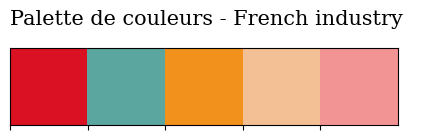

In [2]:
sns.palplot(["#D91122", "#5BA69E", "#F2911B", "#F2C094", "#F29494"])
plt.title("Palette de couleurs - French industry  ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

In [3]:
#ouverture du déscriptif des variables et création d'un dictionnaire pour utilisation ultérieure
desc_var = pd.read_csv('../files/description_variables.csv', sep=';')
desc_var_dic = dict(list(zip(desc_var['CODVAR'], desc_var['Description'])))
theme_var_dic = dict(list(zip(desc_var['CODVAR'], desc_var['thème'])))

# <font color='#5BA69E'>IMPORT DATASET 2020 ET EXPLORATION</font> ##

In [4]:
df = pd.read_csv('../files/all_content_2020_v5.csv', dtype={'CODGEO': 'string'})

In [5]:
df.shape

(34955, 738)

Pour étudier les corrélations entre variables, le dataset doit être propre.
Or, sur les 738 variables qui constituent notre dataset, beaucoup présentent des problèmes. La très grande majorité de nos variables devrait être de type numérique et devrait pouvoir être convertie en "float"

Pour étudier les variables à nettoyer, on constitue un dictionnaire des colonnes présentant des données inconvertibles en "float":

In [6]:
no_float_dic = {}

for i in df.columns:
    no_float = []
    for j in df[i]:
        try:
            float(j)
        except:
            no_float.append(j)
    if np.size(no_float) > 0:
        no_float_dic[i] = np.size(np.unique(no_float))


On transforme désormais ce dictionnaire en dataframe pour une meilleure lisibilité

In [7]:
no_float_df = pd.DataFrame(no_float_dic.items(), columns=['Col', 'non_float_unique'])

On y ajoute les déscriptions des variables

In [8]:
#utilisation du dictionnaire des variables créé en début de notebook
no_float_df['description'] = no_float_df.Col.map(desc_var_dic)

In [9]:
no_float_df.head(50)

,Col,non_float_unique,description
0,CODGEO,360,Code commune INSEE
1,EU_circo,8,Zone France
2,num_dep,2,Numéro du département
3,nom_commune,32692,Nom de la commune
4,nom_dep,101,Nom du département
5,nom_region,18,Nom de la région
6,num_chef_lieu,1,CODGEO du chef lieu de région
7,nom_chef_lieu,18,Nom du chef lieu de région
8,NBMENFISC20,2,Nombre de ménages fiscaux
9,NBPERSMENFISC20,2,Nombre de personnes dans les ménages fiscaux


**Les index 8 à 34 sont, d'après leur description, des données numériques malgré la présence de non floats**

In [10]:
#transformation du tableau pour n'avoir que les index 8 à 34
no_float_df = no_float_df.iloc[8:,].reset_index(drop=True)
no_float_df.head()

,Col,non_float_unique,description
0,NBMENFISC20,2,Nombre de ménages fiscaux
1,NBPERSMENFISC20,2,Nombre de personnes dans les ménages fiscaux
2,MED20,2,Médiane du niveau vie (€)
3,PIMP20,73,Part des ménages fiscaux imposés (%)
4,TP6020,45,Taux de pauvreté-Ensemble (%)


Nous devons désormais identifier les problèmes et décider des solutions à appliquer.

La boucle ci-dessous recense sous forme de dictionnaire les données ne pouvant être converties en float. On affiche uniquement les données uniques pour une meilleure visibilité. Ce dictionnaire n'est qu'un support visuel et n'a pas vocation à être utilisé ultérieurement pour le code.

In [11]:
no_float = {}
for i in no_float_df.Col:
    no_float[i] = []
    for j in df[i]:
        try:
            float(j)
        except:
            if j not in no_float[i]:
                no_float[i].append(j)
    no_float[i] = np.unique(no_float[i])

print(no_float)

{'NBMENFISC20': array(['nd', 's'], dtype='<U2'), 'NBPERSMENFISC20': array(['nd', 's'], dtype='<U2'), 'MED20': array(['nd', 's'], dtype='<U2'), 'PIMP20': array(['15,0', '16,0', '17,0', '18,0', '19,0', '20,0', '21,0', '22,0',
       '23,0', '24,0', '25,0', '26,0', '27,0', '28,0', '29,0', '30,0',
       '31,0', '32,0', '33,0', '34,0', '35,0', '36,0', '37,0', '38,0',
       '39,0', '40,0', '41,0', '42,0', '43,0', '44,0', '45,0', '46,0',
       '47,0', '48,0', '49,0', '50,0', '51,0', '52,0', '53,0', '54,0',
       '55,0', '56,0', '57,0', '58,0', '59,0', '60,0', '61,0', '62,0',
       '63,0', '64,0', '65,0', '66,0', '67,0', '68,0', '69,0', '70,0',
       '71,0', '72,0', '73,0', '74,0', '75,0', '76,0', '77,0', '78,0',
       '79,0', '80,0', '81,0', '82,0', '83,0', '84,0', '86,0', 'nd', 's'],
      dtype='<U4'), 'TP6020': array(['10,0', '11,0', '12,0', '13,0', '14,0', '15,0', '16,0', '17,0',
       '18,0', '19,0', '20,0', '21,0', '22,0', '23,0', '24,0', '25,0',
       '26,0', '27,0', '28,0', '

**On note deux problèmatiques**

- Des **,** au lieu de **.** sur de nombreuses données numériques
- Des '**nd**', ou '**s**' pour 'non determiné' ou 'secret'

# <font color='#5BA69E'>CONVERSION DES COLONNES EN FLOAT</font> #

Suite à notre observation précédente, il est donc facile de solutionner le problème en remplaçant les virgules par des points et les s ou nd par des NaN

In [12]:
for i in no_float_df.Col:
    df[i] = df[i].astype(str)
    df[i] = df[i].str.replace(',', '.')
    df[i] = df[i].replace(['s', 'nd'], np.nan)
    df[i] = df[i].astype(float)

## <font color='#5BA69E'>POINT SUR LA TP6020</font> ##

La variable TP6020 contient désormais uniquemet des floats ou des NaN 

**% de NaN dans la variable TP6020 :**

In [13]:
np.round(df.TP6020.isna().sum() / len(df),2)

0.88

**Nombre de NaN dans la variable TP6020 :**

In [14]:
df.TP6020.isna().value_counts()

True     30630
False     4325
Name: TP6020, dtype: int64

In [15]:
df.to_csv('../files/dataframe_complet.csv', index=False)

## <font color='#5BA69E'>DATAFRAME DES NAN ET DESCRIPTIONS ##

In [16]:
#Création d'un dataframe qui récapitule le nombre de NaNs par variable
df_isna = pd.DataFrame(df.isna().sum().sort_values(ascending=False))

#Ajout des descriptions des variables pour une meilleure compréhension
df_isna['desc'] = df_isna.index.map(desc_var_dic)
df_isna['theme'] = df_isna.index.map(theme_var_dic)


#Optimisation du nom des colonnes
df_isna.columns = ['isNa', 'desc', 'theme']
df_isna.to_excel('../files/var_desc_et_nan.xlsx')

#On ne garde dans les dataframes que les colonnes présentant des NaN
df_isna = df_isna[df_isna.isNa > 0]

#Affichage du dataframe
pd.set_option('display.max_rows', None)
df_isna.head(200)

,isNa,desc,theme
P19_RP_MIDUR,34843,Maisons ou Immeubles en dur en 2019 (princ),Logement
P19_RP_MIBOIS,34843,Maisons ou Immeubles en bois en 2019 (princ),Logement
P19_RP_CASE,34843,Cases traditionnelles en 2019 (princ),Logement
P19_RP_HABFOR,34843,Habitations de fortune en 2019 (princ),Logement
P19_RP_TTEGOU,34843,Rés princ avec tout à l'égout en 2019 (princ),Logement
P19_RP_CLIM,34843,Rés princ avec pièce climatisée en 2019 (princ),Logement
P19_RP_ELEC,34843,Rés princ avec électricité en 2019 (princ),Logement
P19_RP_EAUCH,34843,Rés princ avec eau chaude en 2019 (princ),Logement
P19_RP_BDWC,34843,Rés princ avec Bain/Douche WC en 2019 (princ),Logement
P19_RP_CHOS,34843,Rés princ avec chauffe-eau solaire en 2019 (pr...,Logement


En parcourant les données, il semble que le nombre de NaN ne soit pas très homogène parmi les variables.  
On décele en revanche des variables avec des nombres de NaN relativement proches.   
On peut à priori les diviser en 3 groupes :

- Groupe > 29K NaN
- Groupe > 3K < 29K NaN
- Groupe < 3K NaN

In [17]:
#Ajout d'une catégorisation en 3 groupes
df_isna['NaN_cat'] = pd.cut(df_isna.isNa, [0,3000,29000,36000], labels=['<3K NaN', '>3K & <29K NaN', '>29K NaN'])

## <font color='#5BA69E'>VISUALISATION DES VARIABLES AVEC NAN ## 

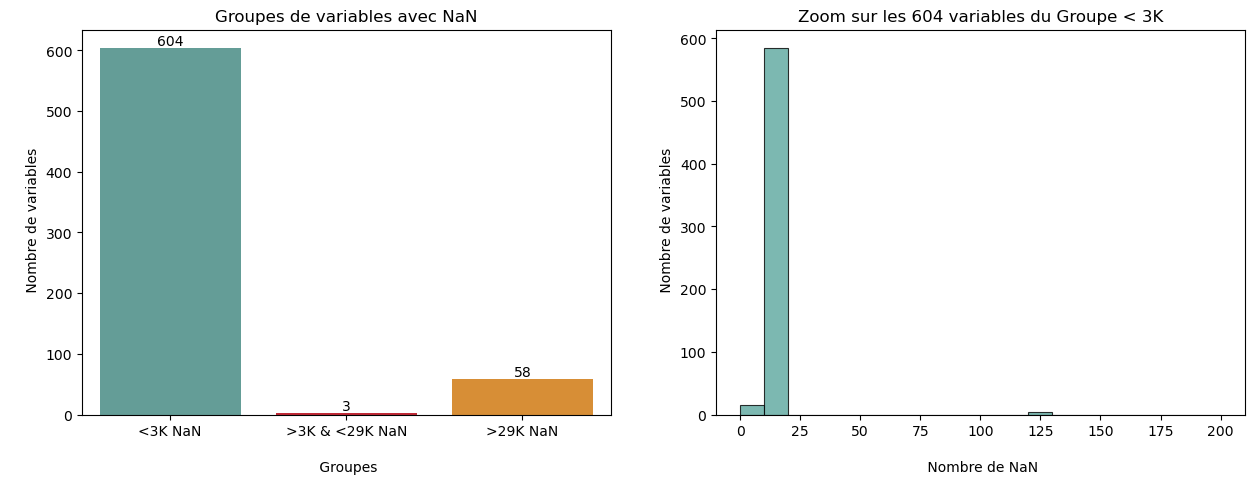

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(121)
ax = sns.countplot(data=df_isna, x='NaN_cat', palette =["#5BA69E","#D91122",  "#F2911B"])
for container in ax.containers:
    ax.bar_label(container)
    
plt.xlabel('\n Groupes')
plt.ylabel('\n Nombre de variables')
plt.title('Groupes de variables avec NaN')
plt.subplot(122)

plt.hist(df_isna.isNa, 
                 bins= 20,
                 range = (0, 200),
                 edgecolor='black',
                 color="#5BA69E",
                 linewidth=0.8,
                 alpha=0.8
                )


plt.xlabel('\n Nombre de NaN')
plt.ylabel('\n Nombre de variables')
plt.title('Zoom sur les 604 variables du Groupe < 3K')

plt.show()

Suite à ces visualisations, on comprend donc que la grande majorité des variables (groupe <3K) ne comporte que peu de NaN et est donc complétement exploitable. Pour rappel, le dataset comporte 34.955 lignes.

Les 3 variables du deuxième groupe (>3K & <29K) ne comportent en réalité respectivement que 3.671 NaN et paraissent donc également exploitables. De plus, la variable MED20, relative au niveau de vie médian, est particlièrement importante pour notre projet. Elle fait partie de ce deuxième groupe.

En revanche, les 58 variables du 3ème groupe sont très incomplètes et les NaN peuvent difficilement être remplacés par des valeurs moyennes ou médianes sans introduire un biais.

Dans ce 3ème groupe, on retrouve cependant la variable TP6020, relative au taux de pauvreté, que l'on souhaite conserver pour une modélisation

A ce stade, on décide de stocker notre dataframe avec les NaN des groupe 1 et 2, tout en conservant la TP6020 du groupe 3 dans :
    
- **df_nan**


In [19]:
df_nan = df

for i in df_isna.itertuples():
    try:
        if (i[1] > 29000) & (i[0] not in ['TP6020']):
            df_nan = df_nan.drop(i[0], axis=1)
    except:
        print(i[0])

Et de stocker un dataframe avec les NaN des groupes 1 et 2 remplacés par des valeurs médianes (hors variables MED20 et TP6020) :

- **df_no_nan**

In [20]:
df_no_nan = df

for i in df_isna.itertuples():
    try:
        if (i[1] > 29000) & (i[0] not in ['TP6020', 'MED20']):
            df_no_nan = df_no_nan.drop(i[0], axis=1)
        else:
            if (i[0] not in ['TP6020', 'MED20']):
                df_no_nan[i[0]] = df_no_nan[i[0]].fillna(df_no_nan[i[0]].median())
    except:
        print(i[0])
    

Visualisation du top 10 en NaN de **df_nan**

In [21]:
df_nan.isna().sum().sort_values(ascending=False).head(10)

TP6020             30630
NBMENFISC20         3671
NBPERSMENFISC20     3671
MED20               3671
P19_RP_SDB           129
P19_RP_CCCOLL        129
P19_RP_CCIND         129
P19_RP_CINDELEC      129
ETPBE120              18
ETTEF5020             18
dtype: int64

Visualisation du top 10 en NaN de **df_no_nan**

In [22]:
df_no_nan.isna().sum().sort_values(ascending=False).head(10)

TP6020              30630
MED20                3671
P19_FACT1524            0
P19_HACTOCC15P          0
P19_ACTOCC15P           0
P19_SAL15P              0
P19_NSAL15P             0
P19_ACTOCC15P_TP        0
P19_SAL15P_TP           0
P19_HSAL15P_TP          0
dtype: int64

## <font color='#5BA69E'>COEFF DE PEARSON TP6020 / df_nan ##

In [23]:
df_6020 = df_nan.dropna().reset_index(drop=True)

In [24]:
df_6020.shape

(4274, 681)

In [25]:
results_dict = {}
pvalue_dict = {}
for i in df_6020.select_dtypes('number').columns:
    test = pearsonr(df_6020.TP6020, df_6020[i])
    results_dict[i] = test[0]
    pvalue_dict[i] = test[1]

df_results = pd.DataFrame(results_dict.items())
df_results['p_value'] = df_results[0].map(pvalue_dict)
df_results.columns = ['col','score_test', 'pvalue']
df_results = df_results[df_results.col != 'TP6020']
df_results['desc'] = df_results.col.map(desc_var_dic)



### Top 10 des variables les plus corrélées positivement avec la TP6020 ###

In [26]:
display(df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).head(10))

,col,score_test,pvalue,desc
0,P19_CHOM_CAPBEP,0.325248,7.117668e-106,Chômeurs CAP-BEP ou équiv. en 2019 (princ)
1,P19_CHOM_DIPLMIN,0.325241,7.191737e-106,Chômeurs Sans diplôme ou CEP en 2019 (princ)
2,C19_PMEN_CS6,0.321670,1.798936e-103,Pop mén Pers Réf Ouvrier en 2019 (compl)
3,P19_RPMAISON_ACH70,0.307348,3.548496e-94,Rés princ Type maison 1946 à 1970 en 2019 (princ)
4,C19_POP2554_CS6,0.298138,1.812294e-88,Pop 25-54 ans Ouvriers en 2019 (compl)
5,C19_MEN_CS6,0.296590,1.574799e-87,Ménages Pers Réf Ouvrier en 2019 (compl)
6,P19_CHOM_BEPC,0.295816,4.618753e-87,"Chômeurs BEPC, brevet des collèges, DNB en 201..."
7,C19_H15P_CS6,0.293191,1.733249e-85,Pop 15 ans ou plus Hommes Ouvriers en 2019 (co...
8,P19_RPMAISON_ACH45,0.292797,2.978922e-85,Rés princ Type maison 1919 à 1945 en 2019 (princ)
9,C19_ACT1564_CS6,0.291261,2.430904e-84,Actifs 15-64 ans Ouvriers en 2019 (compl)


### Top 10 des variables les plus corrélées négativement avec la TP6020 ###

In [27]:
display(df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).tail(10))

,col,score_test,pvalue,desc
662,SUPERF,-0.009267,5.447160e-01,Superficie (en km²)
663,C19_H15P_CS1,-0.010888,4.766880e-01,Pop 15 ans ou plus Hommes Agriculteurs exploit...
664,C19_ACT1564_CS1,-0.011819,4.398246e-01,Actifs 15-64 ans Agriculteurs exploitants en 2...
665,P19_RPMAISON_ACH05,-0.012590,4.105696e-01,Rés princ Type maison 1991 à 2005 en 2019 (princ)
666,C19_PMEN_CS1,-0.012645,4.085538e-01,Pop mén Pers Réf Agri. expl. en 2019 (compl)
667,C19_POP2554_CS1,-0.013457,3.791102e-01,Pop 25-54 ans Agriculteurs exploitants en 2019...
668,ETAZ120,-0.016943,2.681125e-01,Ets actifs agriculture 1 à 9 salariés fin 2020
669,C19_ACTOCC1564_CS1,-0.022213,1.465194e-01,Actifs occ 15-64 ans Agriculteurs exploitants ...
670,num_region,-0.078105,3.179804e-07,Numéro de la région
671,MED20,-0.731338,0.000000e+00,Médiane du niveau vie (€)


In [28]:
#Export du dataframe en csv
df_6020.to_csv('../files/df_nan_TP6020.csv', index=False)

## <font color='#5BA69E'>COEFF DE PEARSON TP6020 / df_no_nan ##

In [29]:
df_6020 = df_no_nan[df_no_nan.TP6020.isna() == False].reset_index(drop=True)
df_6020.shape

(4325, 681)

In [30]:



results_dict = {}
pvalue_dict = {}
for i in df_6020.select_dtypes('number').columns:
    test = pearsonr(df_6020.TP6020, df_6020[i])
    results_dict[i] = test[0]
    pvalue_dict[i] = test[1]

df_results = pd.DataFrame(results_dict.items())
df_results['p_value'] = df_results[0].map(pvalue_dict)
df_results.columns = ['col','score_test', 'pvalue']
df_results = df_results[df_results.col != 'TP6020']
df_results['desc'] = df_results.col.map(desc_var_dic)



### Top 10 des variables les plus corrélées positivement avec la TP6020 ###

In [31]:
display(df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).head(10))

,col,score_test,pvalue,desc
0,P19_CHOM_DIPLMIN,0.357888,7.338508e-131,Chômeurs Sans diplôme ou CEP en 2019 (princ)
1,P19_CHOM_CAPBEP,0.348944,4.558077e-124,Chômeurs CAP-BEP ou équiv. en 2019 (princ)
2,C19_PMEN_CS6,0.323210,1.001156e-105,Pop mén Pers Réf Ouvrier en 2019 (compl)
3,P19_CHOM_BEPC,0.311094,1.092710e-97,"Chômeurs BEPC, brevet des collèges, DNB en 201..."
4,P19_RPMAISON_ACH70,0.304478,1.867002e-93,Rés princ Type maison 1946 à 1970 en 2019 (princ)
5,P19_FSAL15P_EMPAID,0.302072,6.065315e-92,Salariés 15 ans ou plus Femmes Emplois aidés e...
6,C19_POP2554_CS6,0.299092,4.328170e-90,Pop 25-54 ans Ouvriers en 2019 (compl)
7,C19_MEN_CS6,0.297350,5.116565e-89,Ménages Pers Réf Ouvrier en 2019 (compl)
8,C19_H15P_CS6,0.296361,2.065192e-88,Pop 15 ans ou plus Hommes Ouvriers en 2019 (co...
9,P19_HSAL15P_EMPAID,0.296266,2.360918e-88,Salariés 15 ans ou plus Hommes Emplois aidés e...


### Top 10 des variables les plus corrélées négativement avec la TP6020 ###

In [32]:

display(df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).tail(10))

,col,score_test,pvalue,desc
662,C19_F15P_CS3,0.026106,8.604163e-02,"Pop 15 ans ou plus Femmes Cadres, Prof. intel...."
663,ETCKZ21,0.025707,9.095563e-02,Créations d'ets d’activités financières et d'a...
664,ETCKZ20,0.024657,1.049481e-01,Créations d'ets d’activités financières et d'a...
665,ETNJZ21,0.024443,1.079984e-01,Ets d’information et communication au 31 décem...
666,ETCKZ19,0.024038,1.139573e-01,Créations d'ets d’activités financières et d'a...
667,ENNJZ21,0.023142,1.280894e-01,Unités légales d’information et communication ...
668,ENCKZ21,0.023116,1.285109e-01,Créations d'entr. d’activités financières et d...
669,num_region,-0.136678,1.742204e-19,Numéro de la région
670,latitude,-0.272527,1.594127e-74,Latitude
671,MED20,-0.736269,0.000000e+00,Médiane du niveau vie (€)


## <font color='#5BA69E'>CONCLUSION ##

L'étude de corrélations entre la variable TP6020 et le reste de notre dataset (680 autres variables après le traitement des NaN) ne peut donner satisfaction.

Que l'on utilise un dataframe où les NaN ont été remplacés par des valeurs médianes ou que l'on utilise un dataframe ayant conservé les NaN, les résultats de corrélations trouvés sont très similaires.

Seule la variable MED20 montre une corrélation négative relativement importante (-0,73). 

Or, pour notre modélisation, il nous est important de trouver plusieurs variables (entre 3 et 5 idéalement) qui seraient directement corrélées à la variable TP6020.

## <font color='#5BA69E'>COEFF DE PEARSON MED20 / df_nan ##

In [33]:
df_med20 = df_nan.dropna().reset_index(drop=True)
df_med20.shape

(4274, 681)

In [34]:
results_dict = {}
pvalue_dict = {}
for i in df_med20.select_dtypes('number').columns:
    test = pearsonr(df_med20.MED20, df_med20[i])
    results_dict[i] = test[0]
    pvalue_dict[i] = test[1]

df_results = pd.DataFrame(results_dict.items())
df_results['p_value'] = df_results[0].map(pvalue_dict)
df_results.columns = ['col','score_test', 'pvalue']
df_results = df_results[df_results.col != 'MED20']
df_results['desc'] = df_results.col.map(desc_var_dic)

### Top 10 des variables les plus corrélées positivement avec la MED20 ###

In [35]:
display(df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).head(10))

,col,score_test,pvalue,desc
0,P19_ACTOCC15P_ILT5,0.145655,1.062548e-21,Actifs occ 15 ans ou plus travaillent autre ré...
1,Unnamed: 0,0.106101,3.550309e-12,NaN
2,code_postal,0.104405,7.794046e-12,Code postal
3,P19_ACTOCC15P_ILT2P,0.083318,4.899869e-08,Actifs occ 15 ans ou plus travaillent autre co...
4,P19_RPMAISON_ACH05,0.077992,3.306926e-07,Rés princ Type maison 1991 à 2005 en 2019 (princ)
5,C19_PMEN_CS3,0.077980,3.320670e-07,Pop mén Pers Réf Cadres Prof int sup en 2019 (...
6,P19_ACTOCC15P_ILT3,0.074137,1.222074e-06,Actifs occ 15 ans ou plus travaillent autre dé...
7,C19_POP55P_CS3,0.073961,1.295369e-06,"Pop 55 ans ou plus Cadres, Prof. intel. sup. e..."
8,ETAUTRES20,0.073134,1.699842e-06,Particuliers employeurs autres fin 2020
9,C19_H15P_CS3,0.070629,3.803620e-06,"Pop 15 ans ou plus Hommes Cadres, Prof. intel...."


### Top 10 des variables les plus corrélées négativement avec la MED20 ###

In [36]:
display(df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).tail(10))

,col,score_test,pvalue,desc
662,C19_MEN_CS1,-0.139853,4.096072e-20,Ménages Pers Réf Agri. expl. en 2019 (compl)
663,C19_AGRILT_NSAL,-0.139884,4.017620e-20,Emplois non-salariés au LT Agriculture en 2019...
664,C19_MEN_CS6,-0.140778,2.311179e-20,Ménages Pers Réf Ouvrier en 2019 (compl)
665,C19_POP2554_CS6,-0.141450,1.521576e-20,Pop 25-54 ans Ouvriers en 2019 (compl)
666,C19_EMPLT_CS1,-0.143852,3.360649e-21,Agriculteurs exploitants au LT en 2019 (compl)
667,P19_CHOM_DIPLMIN,-0.147769,2.705084e-22,Chômeurs Sans diplôme ou CEP en 2019 (princ)
668,P19_RPMAISON_ACH70,-0.147784,2.679594e-22,Rés princ Type maison 1946 à 1970 en 2019 (princ)
669,P19_CHOM_CAPBEP,-0.156612,7.102768e-25,Chômeurs CAP-BEP ou équiv. en 2019 (princ)
670,C19_PMEN_CS6,-0.157323,4.337246e-25,Pop mén Pers Réf Ouvrier en 2019 (compl)
671,TP6020,-0.731338,0.000000e+00,Taux de pauvreté-Ensemble (%)


## <font color='#5BA69E'>COEFF DE PEARSON MED20 / df_no_nan ##

In [37]:
df_med20 = df_no_nan[df_no_nan.MED20.isna() == False].reset_index(drop=True)
df_med20 = df_med20.dropna().reset_index(drop=True)

In [38]:
results_dict = {}
pvalue_dict = {}
for i in df_med20.select_dtypes('number').columns:
    test = pearsonr(df_med20.MED20, df_med20[i])
    results_dict[i] = test[0]
    pvalue_dict[i] = test[1]

df_results = pd.DataFrame(results_dict.items())
df_results['p_value'] = df_results[0].map(pvalue_dict)
df_results.columns = ['col','score_test', 'pvalue']
df_results = df_results[df_results.col != 'MED20']
df_results['desc'] = df_results.col.map(desc_var_dic)

### Top 10 des variables les plus corrélées positivement avec la MED20 ###

In [39]:
display(df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).head(10))

,col,score_test,pvalue,desc
0,P19_ACTOCC15P_ILT5,0.145927,5.122597e-22,Actifs occ 15 ans ou plus travaillent autre ré...
1,latitude,0.129002,1.638610e-17,Latitude
2,P19_ACTOCC15P_ILT2P,0.080473,1.162161e-07,Actifs occ 15 ans ou plus travaillent autre co...
3,C19_PMEN_CS3,0.076915,4.097579e-07,Pop mén Pers Réf Cadres Prof int sup en 2019 (...
4,Unnamed: 0,0.076859,4.179135e-07,NaN
5,P19_ACTOCC15P_ILT3,0.075245,7.268409e-07,Actifs occ 15 ans ou plus travaillent autre dé...
6,C19_POP55P_CS3,0.072837,1.625754e-06,"Pop 55 ans ou plus Cadres, Prof. intel. sup. e..."
7,code_postal,0.070809,3.142963e-06,Code postal
8,C19_H15P_CS3,0.069845,4.273304e-06,"Pop 15 ans ou plus Hommes Cadres, Prof. intel...."
9,ETAUTRES20,0.068892,5.767051e-06,Particuliers employeurs autres fin 2020


### Top 10 des variables les plus corrélées négativement avec la MED20 ###

In [40]:
display(df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).tail(10))

,col,score_test,pvalue,desc
662,C19_PMEN_CS1,-0.171866,5.008086e-30,Pop mén Pers Réf Agri. expl. en 2019 (compl)
663,P19_CHOM_DIPLMIN,-0.173170,1.824131e-30,Chômeurs Sans diplôme ou CEP en 2019 (princ)
664,C19_ACT1564_CS1,-0.175925,2.104307e-31,Actifs 15-64 ans Agriculteurs exploitants en 2...
665,C19_POP15P_CS1,-0.176370,1.480153e-31,Pop 15 ans ou plus Agriculteurs exploitants en...
666,C19_H15P_CS1,-0.176408,1.436381e-31,Pop 15 ans ou plus Hommes Agriculteurs exploit...
667,P19_CHOM_CAPBEP,-0.176509,1.326063e-31,Chômeurs CAP-BEP ou équiv. en 2019 (princ)
668,C19_AGRILT_NSAL,-0.176807,1.046481e-31,Emplois non-salariés au LT Agriculture en 2019...
669,C19_MEN_CS1,-0.178820,2.093980e-32,Ménages Pers Réf Agri. expl. en 2019 (compl)
670,C19_EMPLT_CS1,-0.180426,5.718556e-33,Agriculteurs exploitants au LT en 2019 (compl)
671,TP6020,-0.736269,0.000000e+00,Taux de pauvreté-Ensemble (%)
